In [1]:
import psycopg2, pandas as pd

In [2]:
def query_database(connection, sql, *args, **kwargs):
    if connection.get_transaction_status() == 3:
        connection.reset()
    with connection.cursor() as cursor:
        cursor.execute(sql, *args, **kwargs)
        rows = cursor.fetchall()
        columns = [d[0] for d in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    return df

In [3]:
connection = psycopg2.connect('postgres://fga@localhost/fga')

In [5]:
sql = ''' 
with distinct_events as (
    select distinct
        device_id, 
        session_id, 
        action

    from session_events 
    
), event_counts as (
    select
        action,
        "DeviceOS" as client,
        count(1)
        
    from distinct_events l join devices r on l.device_id=r."Id"
    
    group by 1, 2
    
), n_sessions as (
    select
        "DeviceOS" as client,
        count(*)
        
    from (
        select distinct
            device_id,
            session_id
            
        from distinct_events
    ) a join devices on a.device_id=devices."Id"
    
    group by 1
            
), results as (
    select
        client,
        action, 
        l.count as n_actions,
        r.count as n_sessions
        
    from event_counts l join n_sessions r 
        using(client)
    
)

select * from results

'''

df = query_database(connection, sql)
df.head()

,client,action,n_actions,n_sessions
0,iOS,FINALIZE_QUIZ_SUBMIT,12,25205
1,iOS,LOADED,21846,25205
2,Android,OPEN_TutorialPage,303,39679
3,Android,showRewardVideoAd.adMob.show,4,39679
4,iOS,START_QUIZ,12412,25205


In [25]:
sql = ''' 
with session_events as (
    select * from session_events
    
), session_starts as (
    select
        device_id,
        session_id,
        min(ts) as start_ts
        
    from session_events
    
    group by 1, 2
    
), actions_seen as (
    select distinct
        device_id,
        session_id,
        action
        
    from session_events
    
), actions_count as (
    select
        start_ts::date as date,
        "DeviceOS" as client,
        action,
        count(1)
        
    from actions_seen l join devices r
        on l.device_id = r."Id"
        join session_starts using (device_id, session_id)
    
    group by 1, 2, 3
    
), sessions_count as (
    select
        start_ts::date as date,
        "DeviceOS" as client,
        count(1)
        
    from session_starts join devices 
        on session_starts.device_id = devices."Id"
    
    group by 1, 2
    
), results as (
    select
        date,
        client,
        action,
        l.count,
        r.count as n_sessions,
        l.count::float / r.count * 100 as percent
        
    from actions_count l join sessions_count r
        using (date, client)
        
    order by client, date, count desc
)

select * from results

'''
df = query_database(connection, sql)
df.head()

,date,client,action,count,n_sessions,percent
0,2019-10-14,Android,APP_COMPONENT_StartApp,655,655,100.000000
1,2019-10-14,Android,APP_STARTUP,644,655,98.320611
2,2019-10-14,Android,APP_PAUSED,578,655,88.244275
3,2019-10-14,Android,LOADED,536,655,81.832061
4,2019-10-14,Android,CONSTRUCTOR,456,655,69.618321


In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
1 % len(colour_cycle)

1

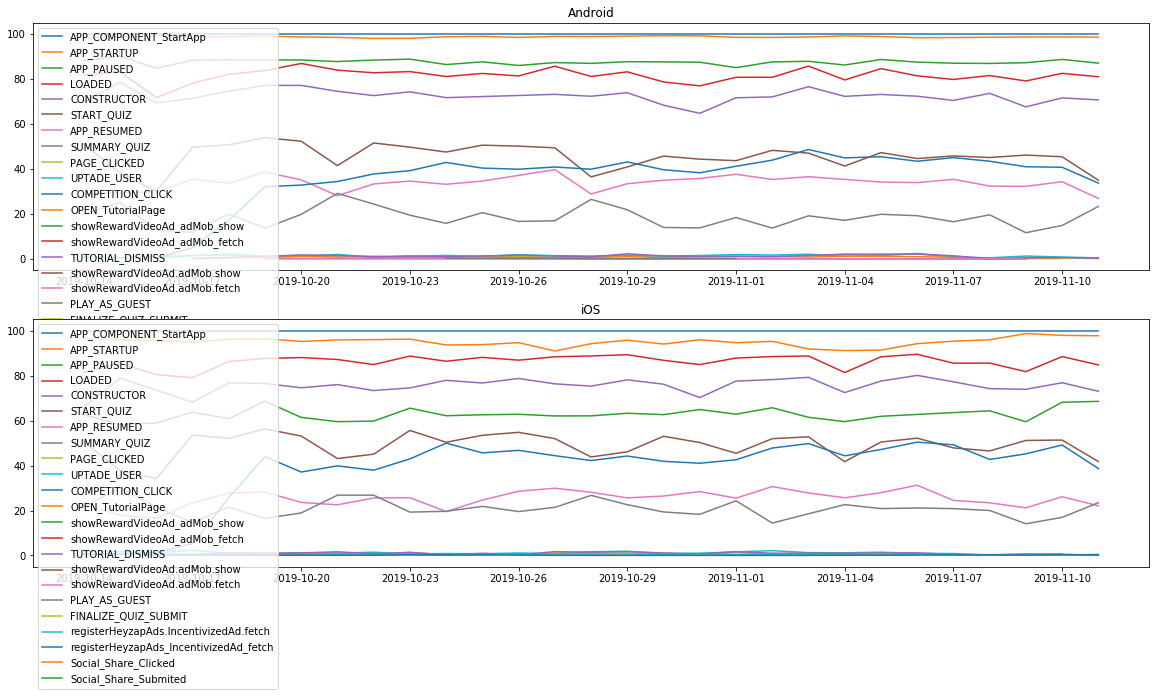

In [42]:
actions = df['action'].unique()
colour_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(2, 1, figsize=(20, 10))
for i, (client, df_) in enumerate(df.groupby('client')):
    ax = axes[i]
    for i, action in enumerate(actions):
        df__ = df_[df_['action'] == action]
        color = colour_cycle[i % len(colour_cycle)]
        ax.plot(df__['date'], df__['percent'], label=action, color=color)
    ax.set_title(client)
    ax.legend()

new users

* APP_STARTUP
* action = loaded, param = SIGNUP PAGE
* register as gues
* open_tutorialpage
* tutorial_dismiss
* (homepage_loaded)
* initialize_quiz
* finalize quiz submit

in 10 minutes


In [1]:
# fabric
# firebase